In [2]:
from tqdm import tqdm
import numpy as np

# label = 'focal'
label = 'no_trans_layer'
grulabel = ''
mixlabel = ''

gru_c1layers=[[16,5,5,'valid',False],[16,5,1,'same',False],[16,5,1,'same',False]]
gru_rlayers=[]
gru_c2layers=[[16,5,5,'valid']]
#gru_c2layers=[[32,1,1,'valid'],[32,1,1,'valid']]
gru_dlayers=[32,32]

doGRUTrain = False

patchSize = 100
c1layers=[32]
m1layers=[32,patchSize]
m2layers=[32,32]
d1layers=[16,1]
d2layers=[16]

doMLPMixTrain = False

loss_fn = "categorical_focal_crossentropy"
learningRate = 1e-3

nEpochs = 25
batchSize = 64

In [3]:
def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


In [4]:
data = load_data("./processed_data_train/",
                 ["batch_0.npz",
                #   "batch_1.npz",
                #   "batch_2.npz",
                #   "batch_3.npz",
                #   "batch_4.npz",
                 ])
data = {d:data[d][:1000] for d in data} # reduce size in memory

In [5]:
testdata = load_data("./processed_data_test/",
                     ["batch_0.npz",
                      "batch_1.npz",
                      "batch_2.npz",
                      "batch_3.npz",
                      "batch_4.npz",
                    ])

In [6]:
print(data['wf_i'].shape)
print(data['mom'].shape)
print(data['tag_times'].shape)
print(data['tag_values'].shape)

(1000, 3000)
(1000,)
(1000, 300)
(1000, 300)


In [7]:
#print(data['wf_i'][0])
print(data['mom'][1])
#print(data['tag_times'][0])
# print(data['tag_values'][0])

6.296549


In [8]:
def expand_values(values, times, tlength=3000, ohe=True, combine=False):
    # values: (300,)
    # times: (300,)
    data = np.zeros((tlength,), dtype=np.float32)

    # Place values at the correct times
    valid_mask = (times >= 0) & (times < tlength)
    times = times[valid_mask]
    values = values[valid_mask]

    data[times] = values

    if ohe:
        ohe_data = np.zeros((tlength, 3), dtype=np.float32)
        for i in range(3):
            ohe_data[:, i] = (data == i).astype(np.float32)
        if combine:
            ohe_data[:, 1] = np.any(ohe_data[:, 1:], axis=-1)
            ohe_data[:, 2] = 0.0
        return ohe_data
    else:
        if combine:
            data = (data > 0).astype(np.float32)
        return data[:, None]  # shape (3000, 1)
    
def np_expand_values(values,times,tlength = 3000, ohe = True, combine = False):
    data = np.zeros((values.shape[0],tlength))
    data[np.arange(times.shape[0])[:,None],times] = values
    if ohe:
        data = np.concatenate([(data==i)[:,:,None] for i in range(3)],axis=-1).astype(np.float32)
        if combine:
            data[:,:,1] = np.any(data[:,:,1:],axis=-1)
            data[:,:,2] = 0.
    else:
        if combine:
            data = (data>0).astype(np.float32)
    return data

def batched_expand_values(values, times, batch_size=1000, tlength=3000, ohe=True, combine=False):
    outputs = []
    for i in tqdm(range(0, len(values), batch_size)):
        v_batch = values[i:i+batch_size]
        t_batch = times[i:i+batch_size]
        out = np_expand_values(v_batch, t_batch, tlength=tlength, ohe=ohe, combine=combine)
        outputs.append(out)
    return np.concatenate(outputs, axis=0)

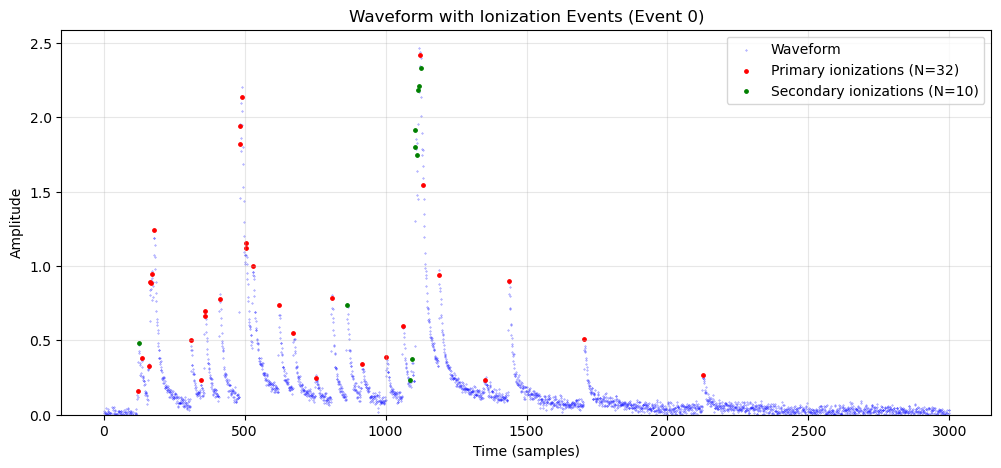

In [9]:
import matplotlib.pyplot as plt

iev = 0
plt.figure(figsize=(12, 5))

plt.scatter(np.arange(data['wf_i'][iev].shape[0]), data['wf_i'][iev], s=0.1, 
           color='blue', alpha=0.6, label='Waveform')

primary_mask = data['tag_values'][iev] == 1
plt.scatter(data['tag_times'][iev, primary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, primary_mask]], 
           s=6, color='r', label=f'Primary ionizations (N={np.sum(primary_mask)})')

secondary_mask = data['tag_values'][iev] == 2
plt.scatter(data['tag_times'][iev, secondary_mask], 
           data['wf_i'][iev][data['tag_times'][iev, secondary_mask]], 
           s=6, color='g', label=f'Secondary ionizations (N={np.sum(secondary_mask)})')

plt.ylim(0)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title(f'Waveform with Ionization Events (Event {iev})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
import tensorflow as tf
from tensorflow import keras
# Import tf/keras modules
from keras.layers import Dense
from keras.layers import Input
# This clears the Keras session
tf.keras.backend.clear_session()

In [11]:
import os, sys

def load_npz_individual(file_path_bytes):
    path = file_path_bytes.decode("utf-8")
    data = np.load(path)
    wf_i = data["wf_i"].astype(np.float32)        # (N, 3000)
    tag_values = data["tag_values"]               # (N, ?)
    tag_times = data["tag_times"]                 # (N, ?)
    return wf_i, tag_values, tag_times

def build_dataset(file_list, batch_size, tlength=3000, ohe=True, combine=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices(file_list)

    def file_to_dataset(file_path):
        wf_i, tag_values, tag_times = tf.numpy_function(
            func=load_npz_individual,
            inp=[file_path],
            Tout=[tf.float32, tf.int32, tf.int32]
        )
        # Shapes are unknown, need to set
        wf_i.set_shape([None, tlength])         # (N, 3000)
        tag_values.set_shape([None, 300])      # (N, ?)
        tag_times.set_shape([None, 300])       # (N, ?)

        ex_ds = tf.data.Dataset.from_tensor_slices((wf_i, tag_values, tag_times))

        def process(wf_i_ex, tag_values_ex, tag_times_ex):
            wf_i_ex = tf.expand_dims(wf_i_ex, axis=-1)  # (3000, 1)
            y = tf.numpy_function(
                func=lambda v, t: expand_values(v, t, tlength, ohe, combine),
                inp=[tag_values_ex, tag_times_ex],
                Tout=tf.float32
            )
            wf_i_ex.set_shape([tlength, 1])
            y.set_shape([tlength, 3])
            return wf_i_ex, y

        return ex_ds.map(process, num_parallel_calls=tf.data.AUTOTUNE)

    #if shuffle:
    #    ds = ds.shuffle(len(file_list))

    ds = ds.flat_map(file_to_dataset)
    ds = ds.shuffle(512)  # shuffle individual examples
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [12]:
from sklearn.model_selection import train_test_split
import glob

# Load file paths
file_list = sorted(glob.glob("./processed_data_train/*.npz"))
train_files, val_files = train_test_split(file_list, test_size=0.2, shuffle=True)

train_ds = build_dataset(train_files, batchSize)
val_ds = build_dataset(val_files, batchSize, shuffle=False)

In [13]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, GRU, Reshape, Conv1DTranspose, UpSampling1D

def dndx_gru(c1layers=[[32,1,1,'valid',False]],
             rlayers=[32],
             c2layers=[],#[[32,1,1,'valid'],[32,1,1,'valid']],
             dlayers=[32,32]): 
    inputs = Input(shape=(data['wf_i'].shape[1],1))
    x = inputs
    npool = 0
    for i,c in enumerate(c1layers):
        x = Conv1D(c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if c[4]:
            x = MaxPooling1D(2)(x)
            npool = npool+1
    for i,r in enumerate(rlayers):
        x = GRU(r, 
                activation="tanh",
                recurrent_activation="sigmoid",
                return_sequences=True,
              )(x)
    for i,c in enumerate(c2layers):
        x = Conv1DTranspose((1 if i<len(c2layers)-1 or npool==0 else 2*npool)*c[0],c[1],c[2],padding=c[3],activation="relu")(x)
        if i==len(c2layers)-1 and npool>0:
            x = Reshape((-1,c))(x)
    for i,d in enumerate(dlayers):
        x = Dense(d,activation="relu")(x)
    x = Reshape((3000,-1))(x)
    outputs = Dense(3,activation='softmax')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="gru")

dndxgru = dndx_gru()

print(dndxgru.summary())

Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 3000, 32)       │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 3000, 32)       │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3000, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3000, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3000, 3)        │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,611 (33.64 KB)

 Trainable params: 8,611 (33.64 KB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )

reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_delta=0.,
    min_lr=1.e-7,
)

dndxgru = dndx_gru(gru_c1layers,gru_rlayers,gru_c2layers,gru_dlayers)

print(dndxgru.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
dndxgru.compile(loss=loss_fn, optimizer=opt,
    metrics=["accuracy"])

if doGRUTrain:
    history = dndxgru.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    dndxgru.save('models/dndxgru_%s.keras'%(label+grulabel))
else:
    dndxgru = keras.models.load_model('models/dndxgru_%s.keras'%(label+grulabel))

Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 600, 16)        │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 600, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 600, 16)        │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 3000, 16)       │         1,296 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3000, 32)       │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3000, 32)       │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3000, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3000, 3)        │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,683 (22.20 KB)

 Trainable params: 5,683 (22.20 KB)

 Non-trainable params: 0 (0.00 B)

None


TypeError: Could not deserialize class 'Functional' because its parent module keras.src.engine.functional cannot be imported. Full object config: {'module': 'keras.src.engine.functional', 'class_name': 'Functional', 'config': {'name': 'gru', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 3000, 1], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}, 'registered_name': None, 'name': 'input_2', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_4', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [5], 'strides': [5], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3000, 1]}, 'name': 'conv1d_4', 'inbound_nodes': [[['input_2', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_5', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [5], 'strides': [1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 600, 16]}, 'name': 'conv1d_5', 'inbound_nodes': [[['conv1d_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_6', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [5], 'strides': [1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 600, 16]}, 'name': 'conv1d_6', 'inbound_nodes': [[['conv1d_5', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'UpSampling1D', 'config': {'name': 'up_sampling1d_1', 'trainable': True, 'dtype': 'float32', 'size': 5}, 'registered_name': None, 'build_config': {'input_shape': [None, 600, 16]}, 'name': 'up_sampling1d_1', 'inbound_nodes': [[['conv1d_6', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_7', 'trainable': True, 'dtype': 'float32', 'filters': 16, 'kernel_size': [5], 'strides': [1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3000, 16]}, 'name': 'conv1d_7', 'inbound_nodes': [[['up_sampling1d_1', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3000, 16]}, 'name': 'dense_3', 'inbound_nodes': [[['conv1d_7', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_4', 'trainable': True, 'dtype': 'float32', 'units': 32, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3000, 32]}, 'name': 'dense_4', 'inbound_nodes': [[['dense_3', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Reshape', 'config': {'name': 'reshape_1', 'trainable': True, 'dtype': 'float32', 'target_shape': [3000, -1]}, 'registered_name': None, 'build_config': {'input_shape': [None, 3000, 32]}, 'name': 'reshape_1', 'inbound_nodes': [[['dense_4', 0, 0, {}]]]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_5', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3000, 32]}, 'name': 'dense_5', 'inbound_nodes': [[['reshape_1', 0, 0, {}]]]}], 'input_layers': [['input_2', 0, 0]], 'output_layers': [['dense_5', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': [None, 3000, 1]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'Adam', 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'jit_compile': True, 'is_legacy_optimizer': False, 'learning_rate': 0.0010000000474974513, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'categorical_focal_crossentropy', 'metrics': ['accuracy'], 'loss_weights': None, 'weighted_metrics': None, 'run_eagerly': None, 'steps_per_execution': None, 'jit_compile': None}}

In [14]:
if doGRUTrain:
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val loss')
    plt.legend()

In [15]:
model = tf.keras.models.load_model(
    "models/dndxgru_no_trans_layer.keras",
    custom_objects={"Functional": tf.keras.Model},
    compile=False
)

In [16]:
rawgrupreds = dndxgru.predict(testdata['wf_i'])
print(rawgrupreds.shape)

15625/15625 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step
(500000, 3000, 3)


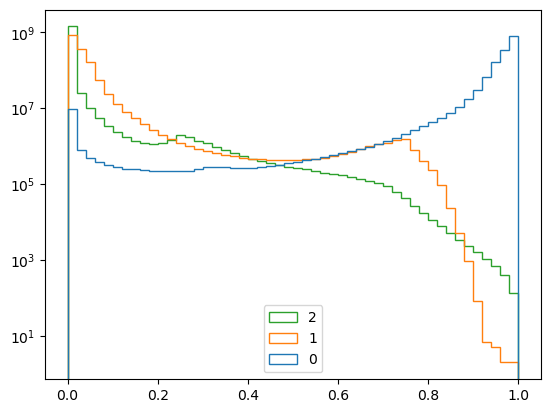

In [16]:
plt.hist(np.reshape(rawgrupreds,(-1,3)),histtype='step',label=np.arange(3),bins=50)
plt.legend()
plt.yscale('log')

In [17]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

def plot_dndx_roc(ysel_test,pred_ytests,log=True):
    for j, alg in enumerate(pred_ytests):
        print(alg)
        fpr, tpr, thresholds = roc_curve(((ysel_test[alg][:,:] if isinstance(ysel_test, dict) else ysel_test[:,:])==0).flatten(),
                                         (pred_ytests[alg][:,:,0]).flatten())
        auc = roc_auc_score(((ysel_test[alg][:,:] if isinstance(ysel_test, dict) else ysel_test[:,:])==0).flatten(), 
                            (pred_ytests[alg][:,:,0]).flatten())
        plt.plot(tpr,fpr, label='%s (AUC=%.3f)'%(alg,auc),linestyle=['solid','dashed','dotted','dashdot'][j])
    
    if log:
        plt.yscale('log')

    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.legend(bbox_to_anchor=(1.05, 1))
    

def plot_dndx_roc(ysel_test, pred_ytests, log=True, batch_size=1000000, fpr_points=100000):
    """
    Computes and averages ROC curves in batches for each algorithm.

    Parameters:
    - ysel_test: array or dict of arrays of shape [N, ...]
    - pred_ytests: dict of arrays of shape [N, ..., 1]
    - batch_size: int, number of samples per batch
    - fpr_points: int, number of fixed FPR points for interpolation
    """
    fixed_fpr = np.linspace(0, 1, fpr_points)

    for j, alg in enumerate(pred_ytests):
        y_true_all = ((ysel_test[alg] if isinstance(ysel_test, dict) else ysel_test) == 0).flatten()
        y_score_all = pred_ytests[alg][:, :, 0].flatten()

        n_samples = len(y_true_all)
        tpr_batches = []

        for i in tqdm(range(0, n_samples, batch_size)):
            y_true_batch = y_true_all[i:i+batch_size]
            y_score_batch = y_score_all[i:i+batch_size]

            # Skip batch if only one class is present (ROC can't be computed)
            if np.unique(y_true_batch).size < 2:
                continue

            fpr, tpr, _ = roc_curve(y_true_batch, y_score_batch)
            interp_tpr = np.interp(fixed_fpr, fpr, tpr, left=0, right=1)
            tpr_batches.append(interp_tpr)

        if not tpr_batches:
            print(f"No valid batches found for algorithm: {alg}")
            continue

        mean_tpr = np.mean(tpr_batches, axis=0)
        final_auc = auc(fixed_fpr, mean_tpr)

        linestyle = ['solid', 'dashed', 'dotted', 'dashdot'][j % 4]
        plt.plot(mean_tpr, fixed_fpr, label=f'{alg} (AUC={final_auc:.3f})', linestyle=linestyle)

    if log:
        plt.yscale('log')

    plt.xlabel('TPR')
    plt.ylabel('FPR')
    plt.legend(bbox_to_anchor=(1.05, 1))

100%|██████████| 500/500 [00:01<00:00, 256.30it/s]


(500000, 3000)


100%|██████████| 1500/1500 [03:18<00:00,  7.54it/s]


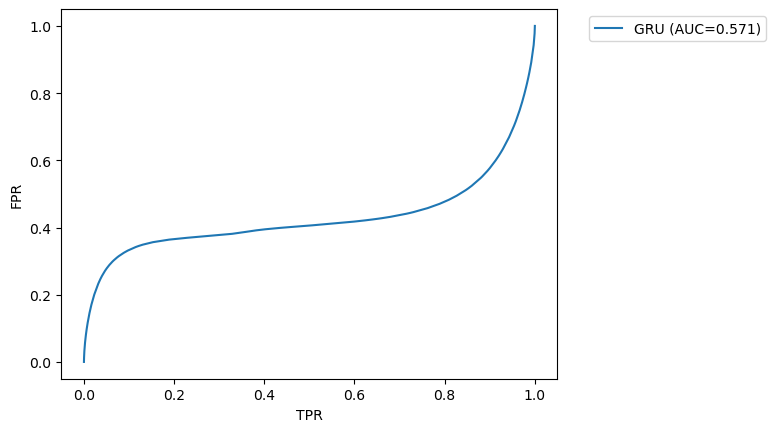

In [18]:
values_test = batched_expand_values(testdata['tag_values'],testdata['tag_times'],ohe=False)
print(values_test.shape)
plot_dndx_roc(values_test,
              {'GRU':rawgrupreds,
              },log=False)

/var/folders/sl/kg210q0j0jbbhk4z3y7k68zw0000gn/T/ipykernel_7916/956736678.py:6: RuntimeWarning: invalid value encountered in scalar divide
  plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>-1]>0) for t in tsteps],


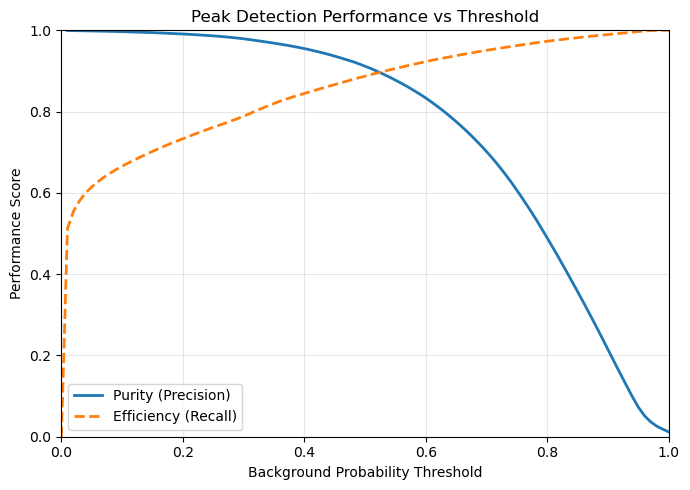

In [ ]:
ntest = 10000
tsteps = np.linspace(0.,1.,101)

plt.figure(figsize=(7, 5))

plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>-1]>0) for t in tsteps],
         label='Purity (Precision)', linewidth=2)
plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>-1) for t in tsteps],
         label='Efficiency (Recall)', linestyle='dashed', linewidth=2)

plt.xlabel('Background Probability Threshold')
plt.ylabel('Performance Score')
plt.title('Peak Detection Performance vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

/var/folders/sl/kg210q0j0jbbhk4z3y7k68zw0000gn/T/ipykernel_13718/2643798338.py:6: RuntimeWarning: invalid value encountered in scalar divide
  plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>-1]>0) for t in tsteps],


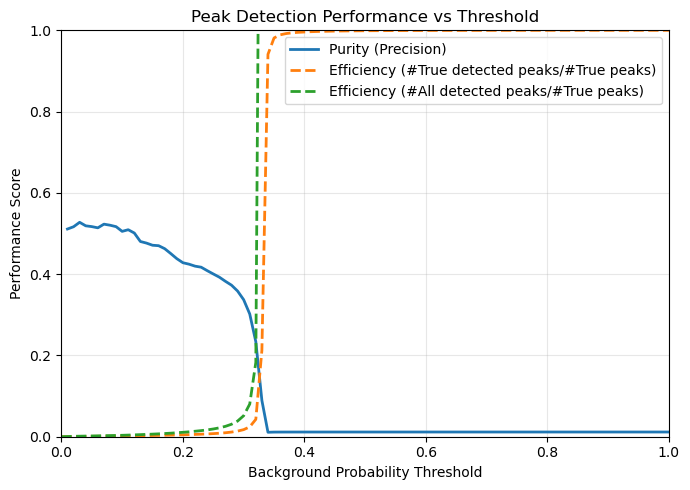

In [ ]:
ntest = 10000
tsteps = np.linspace(0.,1.,101)

plt.figure(figsize=(7, 5))

plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>-1]>0) for t in tsteps],
         label='Purity (Precision)', linewidth=2)
plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>-1) for t in tsteps],
         label='Efficiency (#True detected peaks/#True peaks)', linestyle='dashed', linewidth=2)
plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>-1]>0)/np.sum((rawgrupreds[:ntest,:,0]<t)[values_test[:ntest]>0]>-1) for t in tsteps],
         label='Efficiency (#All detected peaks/#True peaks)', linestyle='dashed', linewidth=2)

plt.xlabel('Background Probability Threshold')
plt.ylabel('Performance Score')
plt.title('Peak Detection Performance vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

/var/folders/sl/kg210q0j0jbbhk4z3y7k68zw0000gn/T/ipykernel_13718/1257179785.py:6: RuntimeWarning: invalid value encountered in scalar divide
  plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]>-1]>0) for t in tsteps],


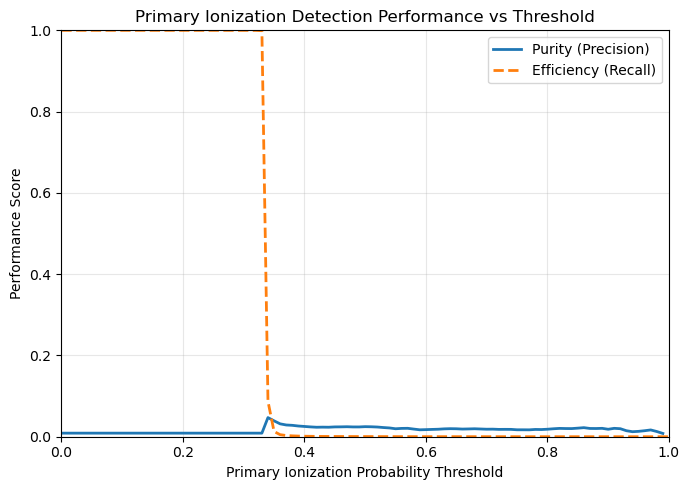

In [20]:
ntest = 10000
tsteps = np.linspace(0.,1.,101)

plt.figure(figsize=(7, 5))

plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]>-1]>0) for t in tsteps],
         label='Purity (Precision)', linewidth=2)
plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>-1) for t in tsteps],
         label='Efficiency (Recall)', linestyle='dashed', linewidth=2)

plt.xlabel('Primary Ionization Probability Threshold')
plt.ylabel('Performance Score')
plt.title('Primary Ionization Detection Performance vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

/var/folders/sl/kg210q0j0jbbhk4z3y7k68zw0000gn/T/ipykernel_7916/2500888683.py:6: RuntimeWarning: invalid value encountered in scalar divide
  plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]>-1]>0) for t in tsteps],


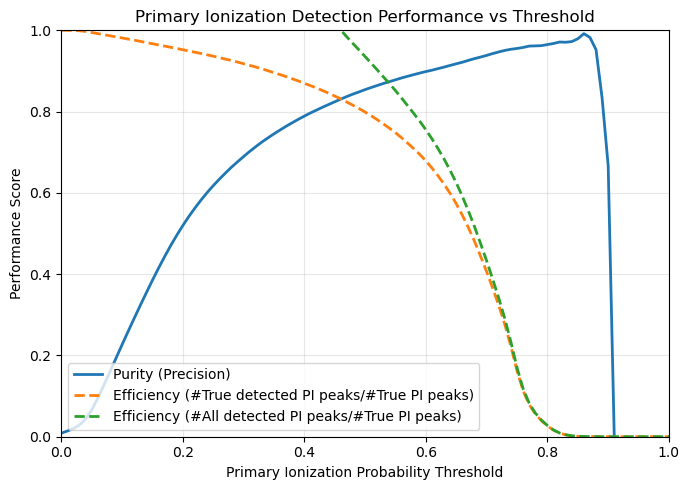

In [51]:
ntest = 10000
tsteps = np.linspace(0.,1.,101)

plt.figure(figsize=(7, 5))

plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]>-1]>0) for t in tsteps],
         label='Purity (Precision)', linewidth=2)
plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>-1) for t in tsteps],
         label='Efficiency (#True detected PI peaks/#True PI peaks)', linestyle='dashed', linewidth=2)
plt.plot(tsteps,[np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]>-1]>0)/np.sum((rawgrupreds[:ntest,:,1]>t)[values_test[:ntest]==1]>-1) for t in tsteps],
         label='Efficiency (#All detected PI peaks/#True PI peaks)', linestyle='dashed', linewidth=2)

plt.xlabel('Primary Ionization Probability Threshold')
plt.ylabel('Performance Score')
plt.title('Primary Ionization Detection Performance vs Threshold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [60]:
# grupreds = (rawgrupreds[:ntest,:,0]<0.554).astype(np.int32)
grupreds = (rawgrupreds[:ntest,:,0]<0.520).astype(np.int32)
print('Efficiency',np.sum(grupreds[values_test[:ntest]>0]>0)/np.sum(grupreds[values_test[:ntest]>0]>-1))
print('Purity',np.sum(grupreds[values_test[:ntest]>0]>0)/np.sum(grupreds[values_test[:ntest]>-1]>0))
print('Efficiency (#All detected peaks/#True peaks)',np.sum(grupreds[values_test[:ntest]>-1]>0)/np.sum(grupreds[values_test[:ntest]>0]>-1))

Efficiency 0.8950859972028293
Purity 0.8990855593376795
Efficiency (#All detected peaks/#True peaks) 0.9955515222179783


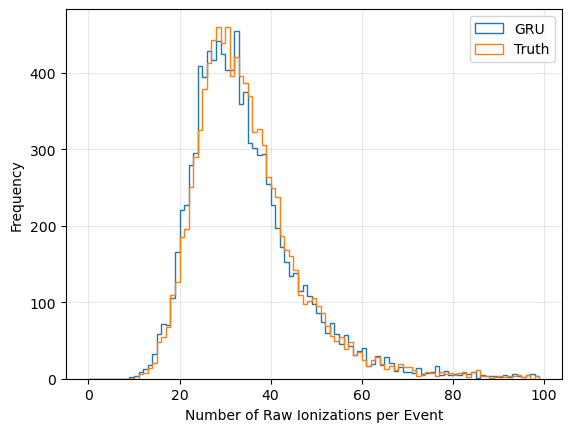

In [56]:
_,bins,_ = plt.hist(np.sum(grupreds>0.520,axis=-1),bins=np.arange(100),histtype='step',label='GRU');
plt.hist(np.sum(testdata['tag_values'][:ntest]>0,axis=-1),bins=bins,histtype='step',label='Truth');
plt.xlabel('Number of Raw Ionizations per Event')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.legend()

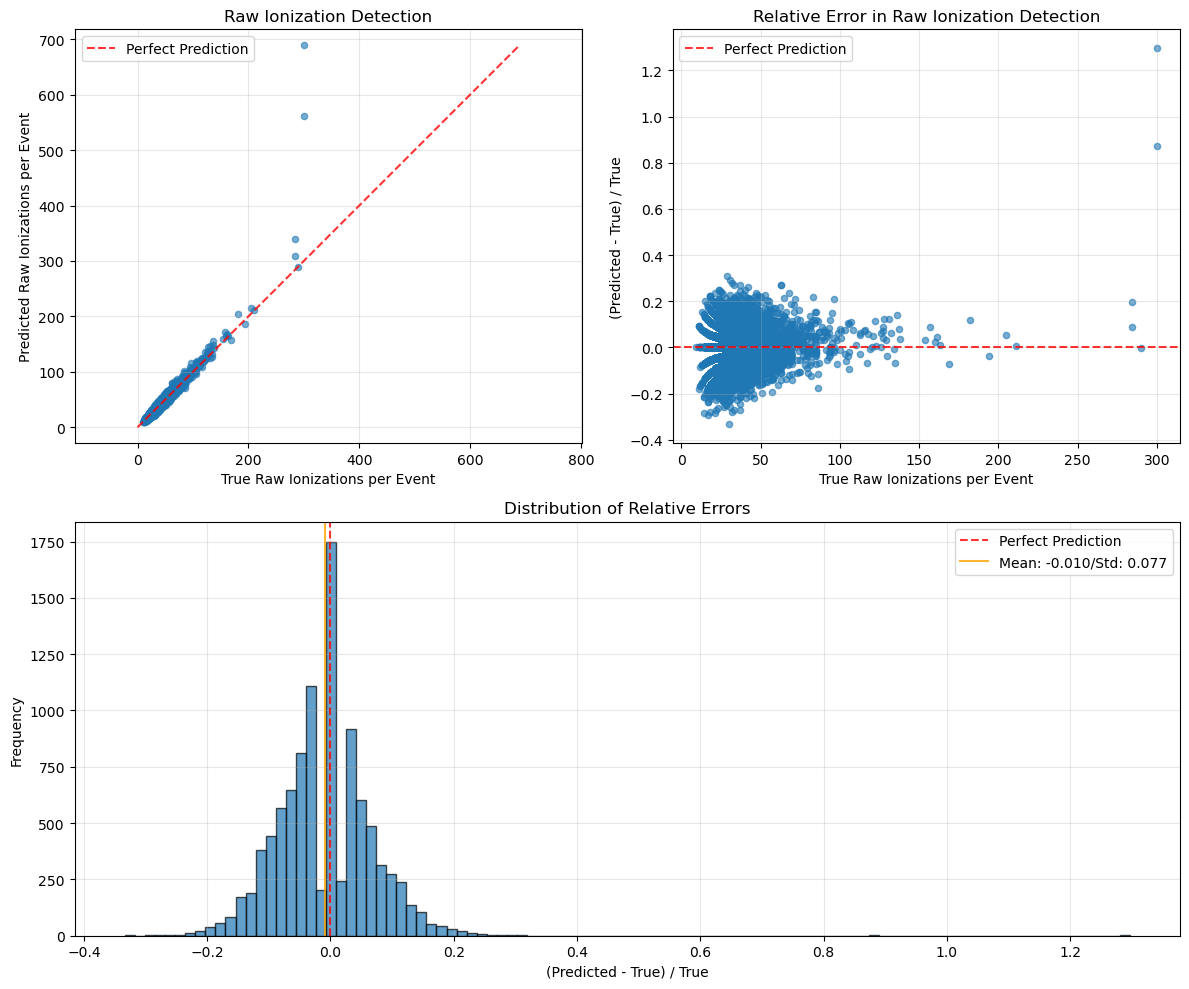

Mean relative error: -0.010
Std relative error: 0.077
Events with zero true peaks: 0 / 10000
Median relative error: 0.000


In [63]:
plt.figure(figsize=(12, 10))

true_peaks = np.sum(testdata['tag_values'][:ntest]>0, axis=-1)  
pred_peaks = np.sum(grupreds>0.520, axis=-1)               

plt.subplot(2, 2, 1)
plt.scatter(true_peaks, pred_peaks, alpha=0.6, s=20)
plt.plot([0, max(true_peaks.max(), pred_peaks.max())], 
         [0, max(true_peaks.max(), pred_peaks.max())], 
         'r--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('True Raw Ionizations per Event')
plt.ylabel('Predicted Raw Ionizations per Event')
plt.title('Raw Ionization Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
mask = true_peaks > 0
relative_error = (pred_peaks[mask] - true_peaks[mask]) / true_peaks[mask]

plt.scatter(true_peaks[mask], relative_error, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('True Raw Ionizations per Event')
plt.ylabel('(Predicted - True) / True')
plt.title('Relative Error in Raw Ionization Detection')
plt.grid(True, alpha=0.3)
plt.legend()


plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=100, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8, label='Perfect Prediction')
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8, 
           label=f'Mean: {np.mean(relative_error):.3f}/Std: {np.std(relative_error):.3f}')
plt.xlabel('(Predicted - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

print(f'Mean relative error: {np.mean(relative_error):.3f}')
print(f'Std relative error: {np.std(relative_error):.3f}')
print(f'Events with zero true peaks: {np.sum(~mask)} / {ntest}')
print(f'Median relative error: {np.median(relative_error):.3f}')

In [64]:
# grupreds = (rawgrupreds[:ntest,:,1]>0.455).astype(np.int32)
grupreds = (rawgrupreds[:ntest,:,1]>0.453).astype(np.int32)
print('Efficiency',np.sum(grupreds[values_test[:ntest]==1]>0)/np.sum(grupreds[values_test[:ntest]==1]>-1))
print('Purity',np.sum(grupreds[values_test[:ntest]==1]>0)/np.sum(grupreds[values_test[:ntest]>-1]>0))
print('Efficiency (#All detected PI peaks/#True PI peaks)',np.sum(grupreds[values_test[:ntest]>-1]>0)/np.sum(grupreds[values_test[:ntest]==1]>-1))

Efficiency 0.8361245197517486
Purity 0.8263310042163757
Efficiency (#All detected PI peaks/#True PI peaks) 1.0118518069458864


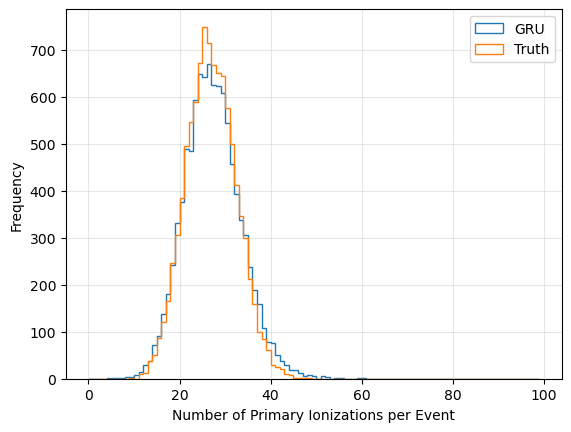

In [59]:
_,bins,_ = plt.hist(np.sum(grupreds>0.453,axis=-1),bins=np.arange(100),histtype='step',label='GRU');
plt.hist(np.sum(testdata['tag_values'][:ntest]==1,axis=-1),bins=bins,histtype='step',label='Truth');
plt.legend()

# plt.title('Distribution of Primary Ionization Events per Waveform')
plt.xlabel('Number of Primary Ionizations per Event')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.show()

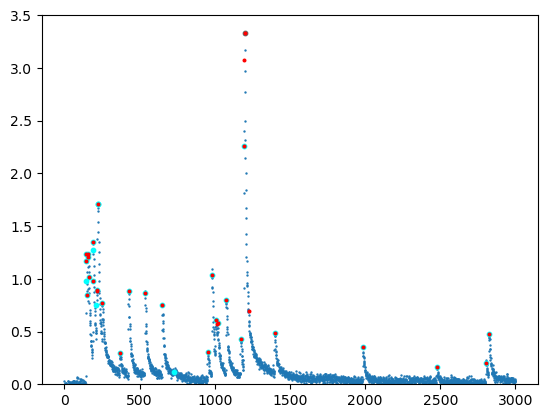

In [24]:
iev = 5
test_true_expand = np_expand_values(testdata['tag_values'][iev:iev+1],testdata['tag_times'][iev:iev+1],tlength = 3000, ohe = True, combine = False)[0]
plt.scatter(np.arange(grupreds[iev].shape[0]),testdata['wf_i'][iev],s=0.5);
plt.scatter(np.arange(grupreds[iev].shape[0])[test_true_expand[:,1]==1],testdata['wf_i'][iev][np.arange(grupreds[iev].shape[0])[test_true_expand[:,1]==1]],s=10.,color='cyan')
plt.scatter(np.arange(grupreds[iev].shape[0])[test_true_expand[:,2]==1],testdata['wf_i'][iev][np.arange(grupreds[iev].shape[0])[test_true_expand[:,2]==1]],s=10.,color='dimgray')
plt.scatter(np.arange(grupreds[iev].shape[0])[grupreds[iev]==1],testdata['wf_i'][iev][np.arange(grupreds[iev].shape[0])[grupreds[iev]==1]],s=3.5,color='r')
plt.scatter(np.arange(grupreds[iev].shape[0])[grupreds[iev]==2],testdata['wf_i'][iev][np.arange(grupreds[iev].shape[0])[grupreds[iev]==2]],s=2.,color='g')
plt.ylim(0)
xstart = 300
#plt.xlim(xstart,xstart+0.5*patchSize)

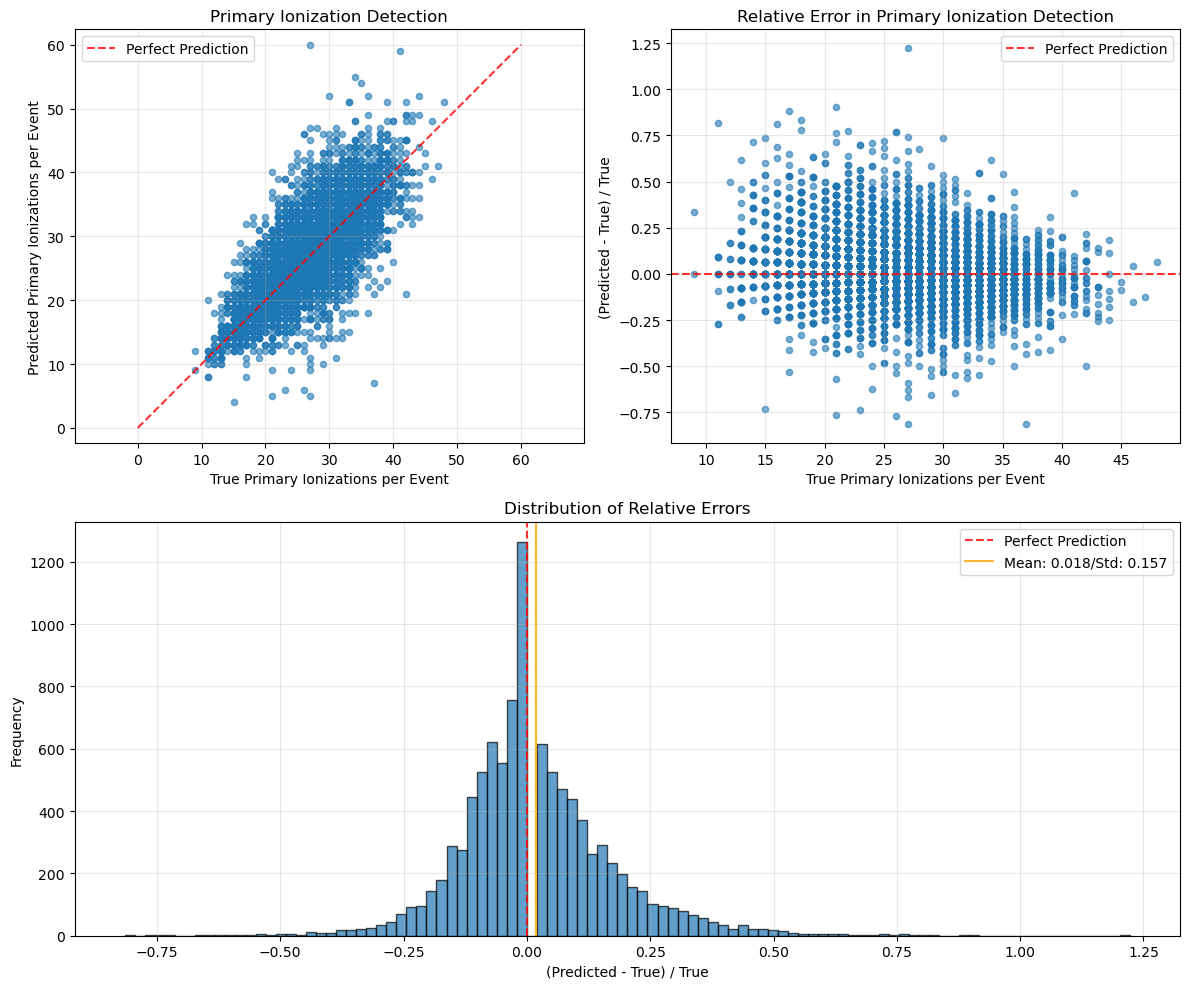

Mean relative error: 0.018
Std relative error: 0.157
Events with zero true peaks: 0 / 10000
Median relative error: 0.000


In [66]:
plt.figure(figsize=(12, 10))

true_primary = np.sum(testdata['tag_values'][:ntest]==1, axis=-1)  
pred_primary = np.sum(grupreds>0.455, axis=-1)               

plt.subplot(2, 2, 1)
plt.scatter(true_primary, pred_primary, alpha=0.6, s=20)
plt.plot([0, max(true_primary.max(), pred_primary.max())], 
         [0, max(true_primary.max(), pred_primary.max())], 
         'r--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('True Primary Ionizations per Event')
plt.ylabel('Predicted Primary Ionizations per Event')
plt.title('Primary Ionization Detection')
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
mask = true_primary > 0
relative_error = (pred_primary[mask] - true_primary[mask]) / true_primary[mask]

plt.scatter(true_primary[mask], relative_error, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.8, label='Perfect Prediction')
plt.xlabel('True Primary Ionizations per Event')
plt.ylabel('(Predicted - True) / True')
plt.title('Relative Error in Primary Ionization Detection')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(relative_error, bins=100, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.8, label='Perfect Prediction')
plt.axvline(x=np.mean(relative_error), color='orange', linestyle='-', alpha=0.8, 
           label=f'Mean: {np.mean(relative_error):.3f}/Std: {np.std(relative_error):.3f}')
plt.xlabel('(Predicted - True) / True')
plt.ylabel('Frequency')
plt.title('Distribution of Relative Errors')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()

plt.show()

print(f'Mean relative error: {np.mean(relative_error):.3f}')
print(f'Std relative error: {np.std(relative_error):.3f}')
print(f'Events with zero true peaks: {np.sum(~mask)} / {ntest}')
print(f'Median relative error: {np.median(relative_error):.3f}')

In [ ]:
from keras.layers import Conv1D, MaxPooling1D, Dense, Input, Flatten, GlobalAveragePooling1D, ZeroPadding1D, GRU, Reshape, LayerNormalization, Add, Lambda, Permute

def dndx_mlpmixer(patchsize=50,c1layers=[32],m1layers=[64,50],m2layers=[64,32],d1layers=[16,1],d2layers=[16,16]): 
    inputs = Input(shape=(data['wf_i'].shape[1],1))
    x = ZeroPadding1D(padding=(patchsize-1, 0))(inputs)
    #(?,3000,1)
    c0 = Conv1D(patchsize,patchsize,1,padding='valid',activation='linear',use_bias=False)
    x = c0(x)
    c0.set_weights([np.identity(patchsize)[:,None,:]])
    c0.trainable = False
    x = Reshape((-1,patchsize,1))(x)
    #(?,3000,patchsize,1)
    for i,c in enumerate(c1layers):
        x = Dense(c,activation="relu")(x)
    #(?,3000,patchsize,feat)
    xm = LayerNormalization()(x)
    #xm = Lambda(lambda tensor:tf.transpose(tensor,perm=(0,2,1)),output_shape=(c1layers[-1][0],int(data['wf_i'].shape[1]/c1layers[-1][1])))(xm)
    xm = Permute((1,3,2))(xm)
    for i,m in enumerate(m1layers):
        xm = Dense(m,activation="gelu" if i==0 else "linear")(xm)
    #xm = Lambda(lambda tensor:tf.transpose(tensor,perm=(0,2,1)),output_shape=(int(data['wf_i'].shape[1]/c1layers[-1][1]),c1layers[-1][0]))(xm)
    xm = Permute((1,3,2))(xm)
    xm = Add()([x,xm])
    x = LayerNormalization()(xm)
    for i,m in enumerate(m2layers):
        x = Dense(m,activation="gelu" if i==0 else "linear")(x)
    x = Add()([x,xm])
    for i,d in enumerate(d1layers):
        x = Dense(d,activation="relu")(x)
    x = Reshape((data['wf_i'].shape[1],-1))(x)
    for i,d in enumerate(d2layers):
        x = Dense(d,activation="relu")(x)
    outputs = Dense(3,activation='softmax')(x)
    
    return keras.Model(inputs=inputs, outputs=outputs, name="mlpmixer")

dndxmlpmix = dndx_mlpmixer()

print(dndxmlpmix.summary())

In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.optimizers import Adam

earlystop = EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True,
        min_delta=0.0, 
    )
reducelr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=5,
    min_delta=0.,
    min_lr=1.e-7,
)

dndxmlpmix = dndx_mlpmixer(patchSize,c1layers,m1layers,m2layers,d1layers,d2layers)

print(dndxmlpmix.summary())
# Define Optimizer and compile
opt = Adam(learning_rate=learningRate)
dndxmlpmix.compile(loss="categorical_focal_crossentropy", optimizer=opt,
    metrics=["accuracy"])

if doMLPMixTrain:
    history = dndxmlpmix.fit(train_ds, validation_data=val_ds,
                      batch_size=batchSize, epochs=nEpochs, callbacks=(earlystop,reducelr))

    dndxmlpmix.save('models/dndxmlpmix_%s.keras'%(label+mixlabel))
else:
    dndxmlpmix = keras.models.load_model('models/dndxmlpmix_%s.keras'%(label+mixlabel))

In [ ]:
rawmlpmixpreds = dndxmlpmix.predict(testdata['wf_i'])
print(rawmlpmixpreds.shape)

In [ ]:
plt.hist(np.reshape(rawmlpmixpreds,(-1,3)),histtype='step',label=np.arange(3),bins=50)
plt.legend()
plt.yscale('log')

In [ ]:
values_test = batched_expand_values(testdata['tag_values'],testdata['tag_times'],ohe=False)
plot_dndx_roc(values_test,
              {'GRU':rawgrupreds,
               'MLPMixer':rawmlpmixpreds,
              },log=False)

In [ ]:
ntest = 1000
tsteps = np.linspace(0.,1.,101)
plt.plot(tsteps,[np.sum((rawmlpmixpreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawmlpmixpreds[:ntest,:,0]<t)[values_test[:ntest]>-1]>0) for t in tsteps],label='Purity')
plt.plot(tsteps,[np.sum((rawmlpmixpreds[:ntest,:,0]<t)[values_test[:ntest]>0]>0)/np.sum((rawmlpmixpreds[:ntest,:,0]<t)[values_test[:ntest]>0]>-1) for t in tsteps],label='Efficiency',linestyle='dashed')
plt.legend()

In [ ]:
mlpmixpreds = (rawmlpmixpreds[:ntest,:,0]<0.561).astype(np.int32)
print('Efficiency',np.sum(mlpmixpreds[values_test[:ntest]>0]>0)/np.sum(mlpmixpreds[values_test[:ntest]>0]>-1))
print('Purity',np.sum(mlpmixpreds[values_test[:ntest]>0]>0)/np.sum(mlpmixpreds[values_test[:ntest]>-1]>0))

In [ ]:
iev = 1
test_true_expand = np_expand_values(testdata['tag_values'][iev:iev+1],testdata['tag_times'][iev:iev+1],tlength = 3000, ohe = True, combine = False)[0]
plt.scatter(np.arange(mlpmixpreds[iev].shape[0]),testdata['wf_i'][iev],s=0.5);
plt.scatter(np.arange(mlpmixpreds[iev].shape[0])[test_true_expand[:,1]==1],testdata['wf_i'][iev][np.arange(mlpmixpreds[iev].shape[0])[test_true_expand[:,1]==1]],s=10.,color='cyan')
plt.scatter(np.arange(mlpmixpreds[iev].shape[0])[test_true_expand[:,2]==1],testdata['wf_i'][iev][np.arange(mlpmixpreds[iev].shape[0])[test_true_expand[:,2]==1]],s=10.,color='dimgray')
plt.scatter(np.arange(mlpmixpreds[iev].shape[0])[mlpmixpreds[iev]==1],testdata['wf_i'][iev][np.arange(mlpmixpreds[iev].shape[0])[mlpmixpreds[iev]==1]],s=3.5,color='r')
plt.scatter(np.arange(mlpmixpreds[iev].shape[0])[mlpmixpreds[iev]==2],testdata['wf_i'][iev][np.arange(mlpmixpreds[iev].shape[0])[mlpmixpreds[iev]==2]],s=2.,color='g')
plt.ylim(0)
xstart = 300
#plt.xlim(xstart,xstart+0.5*patchSize)

In [ ]:
_,bins,_ = plt.hist(np.sum(grupreds>0,axis=-1),bins=np.arange(100),histtype='step',label='GRU');
plt.hist(np.sum(mlpmixpreds>0,axis=-1),bins=np.arange(100),histtype='step',label='MLPMixer');
plt.hist(np.sum(testdata['tag_values'][:ntest]>0,axis=-1),bins=bins,histtype='step',label='Truth');
plt.legend()

In [ ]:
print("=== TensorFlow Metal GPU 配置 ===")
print(f"TensorFlow版本: {tf.__version__}")
print(f"Python版本: {sys.version}")

# 检查GPU可用性
physical_devices = tf.config.list_physical_devices()
print(f"所有物理设备: {physical_devices}")

gpus = tf.config.list_physical_devices('GPU')
print(f"GPU设备: {gpus}")

if gpus:
    try:
        # 设置GPU内存增长
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"成功配置 {len(gpus)} 个GPU设备（Metal）")
        print("GPU加速已启用")
    except RuntimeError as e:
        print(f"GPU配置错误: {e}")
else:
    print("未检测到GPU设备，将使用CPU")

# 验证Metal是否正常工作
def test_metal():
    print("\n=== 测试Metal GPU ===")
    with tf.device('/GPU:0' if gpus else '/CPU:0'):
        # 创建一个简单的计算来测试GPU
        a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
        b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
        c = tf.matmul(a, b)
        print(f"测试矩阵乘法结果: {c}")
        print(f"计算设备: {c.device}")
    return c

test_result = test_metal()